In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)

In [3]:
salary_file = pd.ExcelFile('../contract_data/salaries_1985to2020_final.xlsx')
salaries = pd.read_excel(salary_file, 0)
players_info = pd.read_excel(salary_file, 1)

In [4]:
### add years of the contract
years = list(salaries.groupby('player_id').apply(lambda x: [i for i in range(1, len(x)+1)]))
flatten = lambda l: [item for sublist in l for item in sublist]
salaries['years'] = flatten(years)

In [5]:
salaries_98_20 = salaries.loc[salaries['season_end'] >= 1999]
unique_ids = list(pd.unique(salaries_98_20['player_id']))
filtered_players_info = players_info.loc[[True if pid in unique_ids else False for pid in players_info['_id']]]

In [6]:
# Deal with rookie contracts of first round picks and second round picks
# separately. 
first_round_picks = filtered_players_info.loc[filtered_players_info['draft_round'] == '1st round']
second_round_picks = filtered_players_info.loc[filtered_players_info['draft_round'] == '2nd round']

In [7]:
salaries_first_round = salaries_98_20.loc[[True if pid in list(first_round_picks['_id']) else False for pid in salaries_98_20['player_id']]].drop(columns=['team'])
# Drop entries with 'years' being 4 or less
# Prior to 2011 CBA, first round rookie contract is a 3+1 contract with the fourth year being team option
# After 2011 CBA, first round rookie contract is a 2+2 contract with both the 3rd and 4th year being team options
# Dropping values will potentially over-dropping some datapoints
salaries_first_round = salaries_first_round.loc[salaries_first_round['years'] > 4]

salaries_second_round = salaries_98_20.loc[[True if pid in list(second_round_picks['_id']) else False for pid in salaries_98_20['player_id']]].drop(columns=['team'])
# Drop entries with 'years' being 3 or less
salaries_second_round = salaries_second_round.loc[salaries_second_round['years'] > 3]

In [8]:
# Following part is for fixing data in all stats

In [9]:
stats = pd.read_excel('../season_data/advanced_stats/FINAL_ADVANCED_STATS/all_seasons_advanced_stats.xlsx')

In [10]:
stats['error_in_name'] = stats['Year'].apply(lambda x: x is np.nan)
stats_need_fix = stats.loc[stats['error_in_name'] == True]

In [11]:
stats_need_fix['Year'] = '2019-20'
name = stats_need_fix['name'].apply(lambda x: re.sub(r"\\.+", "", x))
slug = stats_need_fix['name'].apply(lambda x: re.sub(r".+\\", "", x))
stats_need_fix['name'], stats_need_fix['slug'] = name, slug

In [12]:
stats = stats.loc[stats['error_in_name'] == False].append(stats_need_fix).drop(columns=['error_in_name'])

In [13]:
# Create a primary key in two salaries table for joins
salaries_first_round['key'] = salaries_first_round['player_id'] + " " + salaries_first_round['season']
salaries_second_round['key'] = salaries_second_round['player_id'] + " " + salaries_second_round['season']
stats['key'] = stats['slug'] + " " + stats['Year']

In [14]:
salaries_stats_first_round = salaries_first_round.join(stats.set_index('key'), on='key', how='left')
salaries_stats_second_round = salaries_second_round.join(stats.set_index('key'), on='key', how='left')

In [15]:
first_round_counts = salaries_stats_first_round[['names', 'key']].groupby('key').count()
second_round_counts = salaries_stats_second_round[['names', 'key']].groupby('key').count()
not_traded_mid_season_first_round = list(first_round_counts.loc[first_round_counts['names'] == 1].index)
not_traded_mid_season_second_round = list(second_round_counts.loc[second_round_counts['names'] == 1].index)

In [16]:
np.unique(salaries_stats_first_round['season'])

array(['1998-99', '1999-00', '2000-01', '2001-02', '2002-03', '2003-04',
       '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10',
       '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16',
       '2016-17', '2017-18', '2018-19', '2019-20'], dtype=object)

In [17]:
salaries_stats_first_round.sort_values('win_shares', )

,names,player_id,salary,season,season_end,season_start,key,years,name,positions,age,team,games_played,minutes_played,player_efficiency_rating,true_shooting_percentage,three_point_attempt_rate,free_throw_attempt_rate,offensive_rebound_percentage,defensive_rebound_percentage,total_rebound_percentage,assist_percentage,steal_percentage,block_percentage,turnover_percentage,usage_percentage,offensive_win_shares,defensive_win_shares,win_shares,win_shares_per_48_minutes,offensive_box_plus_minus,defensive_box_plus_minus,box_plus_minus,value_over_replacement_player,is_combined_totals,Year,slug
1068,Michael Beasley,beaslmi01,5750000,2012-13,2013,2012,beaslmi01 2012-13,5,Michael Beasley,SMALL FORWARD,24.0,PHOENIX SUNS,75.0,1554.0,10.8,0.462,0.188,0.164,3.7,17.2,10.3,12.5,1.0,1.6,14.9,27.6,-2.5,1.0,-1.5,-0.047,-2.7,-2.0,-4.7,-1.1,False,2012-13,beaslmi01
10626,Sasha Pavlovic,pavloal01,1250000,2009-10,2010,2009,pavloal01 2009-10,8,Sasha Pavlović,SMALL FORWARD,26.0,MINNESOTA TIMBERWOLVES,71.0,877.0,5.4,0.422,0.393,0.087,1.5,13.6,7.5,10.0,1.3,0.5,14.5,18.1,-1.5,0.3,-1.2,-0.063,-5.0,-1.2,-6.2,-0.9,False,2009-10,pavloal01
10625,Sasha Pavlovic,pavloal01,1500000,2009-10,2010,2009,pavloal01 2009-10,7,Sasha Pavlović,SMALL FORWARD,26.0,MINNESOTA TIMBERWOLVES,71.0,877.0,5.4,0.422,0.393,0.087,1.5,13.6,7.5,10.0,1.3,0.5,14.5,18.1,-1.5,0.3,-1.2,-0.063,-5.0,-1.2,-6.2,-0.9,False,2009-10,pavloal01
9178,Ron Mercer,mercero01,6750000,2001-02,2002,2001,mercero01 2001-02,5,Ron Mercer,SHOOTING GUARD,25.0,CHICAGO BULLS,40.0,1503.0,10.8,0.440,0.079,0.151,3.3,8.9,6.0,15.1,1.1,0.5,9.4,25.8,-1.4,0.3,-1.1,-0.035,-2.0,-2.3,-4.3,-0.9,False,2001-02,mercero01
9231,Darius Miles,milesda01,7250000,2005-06,2006,2005,milesda01 2005-06,6,Darius Miles,SMALL FORWARD,24.0,PORTLAND TRAIL BLAZERS,40.0,1286.0,12.5,0.480,0.020,0.320,2.2,15.0,8.5,10.8,1.8,2.3,14.5,25.1,-1.6,0.6,-1.0,-0.037,-2.5,-0.9,-3.4,-0.4,False,2005-06,milesda01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15101,Sharone Wright,wrighsh01,4000000,1998-99,1999,1998,wrighsh01 1998-99,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15107,Tony Wroten,wroteto01,25000,2016-17,2017,2016,wroteto01 2016-17,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15151,Thaddeus Young,youngth01,12900000,2019-20,2020,2019,youngth01 2019-20,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15163,Cody Zeller,zelleco01,14471910,2019-20,2020,2019,zelleco01 2019-20,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
salary_caps_file = pd.ExcelFile('salary_caps.xlsx')
salary_caps = pd.read_excel(salary_caps_file, 0)
salary_caps = salary_caps.drop(columns=salary_caps.columns[0])
salary_caps_99_20 = salary_caps.set_index('season').loc[np.unique(salaries_stats_first_round['season'])]

In [19]:
salaries_stats_first_round = salaries_stats_first_round.join(salary_caps_99_20, on='season', how='left')
salaries_stats_first_round = salaries_stats_first_round[salaries_stats_first_round['name'].notna()]
salaries_stats_second_round = salaries_stats_second_round.join(salary_caps_99_20, on='season', how='left')
salaries_stats_second_round = salaries_stats_second_round[salaries_stats_second_round['name'].notna()]

In [20]:
salaries_stats_first_round['cap_space_usage'] = salaries_stats_first_round['salary'] / salaries_stats_first_round['salary_cap']
salaries_stats_second_round['cap_space_usage'] = salaries_stats_second_round['salary'] / salaries_stats_second_round['salary_cap']

In [21]:
salaries_stats_first_round['minutes_per_game'] = salaries_stats_first_round['minutes_played'] / salaries_stats_first_round['games_played']
salaries_stats_second_round['minutes_per_game'] = salaries_stats_second_round['minutes_played'] / salaries_stats_second_round['games_played']

In [22]:
def standardize(df, column):
    series = []
    for i in df[column]:
        series.append((i - df[column].mean())/df[column].std())
    return series

def correlation(df, column_1, column_2):
    return np.mean(df[column_1] * df[column_2])

def scatter_and_correlation(df, column_1, column_2):
    copy = df.copy()
    copy[column_1 + "_standard"] = standardize(df, column_1)
    copy[column_2 + "_standard"] = standardize(df, column_2)
    copy.plot.scatter(x = column_1 + "_standard", y = column_2 + '_standard')
    return correlation(copy, column_1 + '_standard', column_2 + '_standard')

In [23]:
max(salaries_stats_first_round['minutes_per_game']), min(salaries_stats_first_round['minutes_per_game'])

(43.7, 1.0)

In [24]:
max(salaries_stats_second_round['minutes_per_game']), min(salaries_stats_second_round['minutes_per_game'])

(42.3, 1.0)

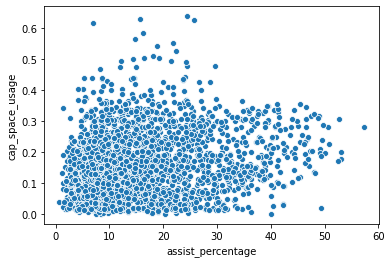

In [25]:
sns.scatterplot(x='assist_percentage', y='cap_space_usage', data=salaries_stats_first_round.loc[(salaries_stats_first_round['minutes_played'] >= 700)])

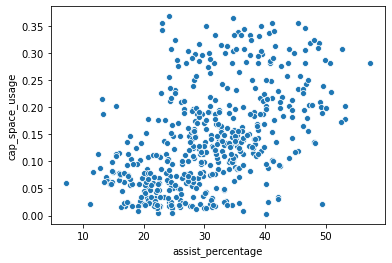

In [30]:
sns.scatterplot(x='assist_percentage', y='cap_space_usage', data=salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == "POINT GUARD") & (salaries_stats_first_round['minutes_played'] >= 700)])

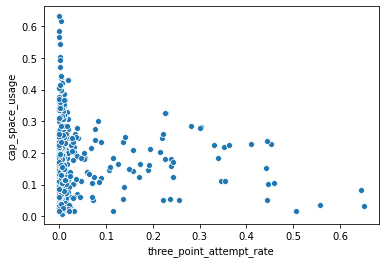

In [26]:
sns.scatterplot(x='three_point_attempt_rate', y='cap_space_usage', data=salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == "CENTER") & (salaries_stats_first_round['minutes_played'] >= 700)])

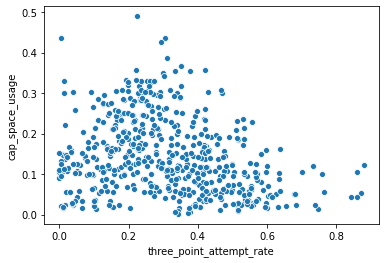

In [28]:
sns.scatterplot(x='three_point_attempt_rate', y='cap_space_usage', data=salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == "SMALL FORWARD") & (salaries_stats_first_round['minutes_played'] >= 700)])

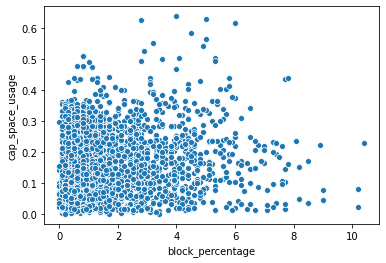

In [27]:
sns.scatterplot(x='block_percentage', y='cap_space_usage', data=salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == "CENTER") & (salaries_stats_first_round['minutes_played'] >= 700)])

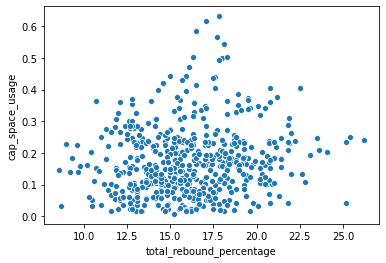

In [26]:
sns.scatterplot(x='total_rebound_percentage', y='cap_space_usage', data=salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == "CENTER") & (salaries_stats_first_round['minutes_played'] >= 700)])

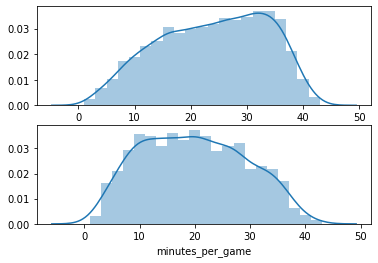

In [27]:
# distributions for filtering first round picks
fig, ax = plt.subplots(2,1)
sns.distplot(salaries_stats_first_round['minutes_per_game'], bins=np.arange(1, 48, 2), ax=ax[0])
sns.distplot(salaries_stats_second_round['minutes_per_game'], bins=np.arange(1, 48, 2), ax=ax[1])

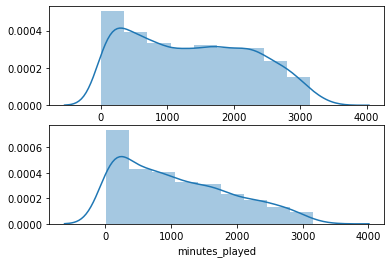

In [39]:
# distributions for filtering first round picks
fig, ax = plt.subplots(2,1)
sns.distplot(salaries_stats_first_round['minutes_played'], bins=np.arange(1, 3500, 350), ax=ax[0])
sns.distplot(salaries_stats_second_round['minutes_played'], bins=np.arange(1, 3500, 350), ax=ax[1])

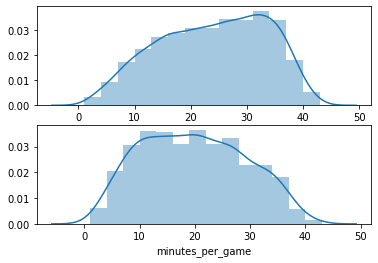

In [36]:
fig, ax = plt.subplots(2,1)
sns.distplot(salaries_stats_first_round['minutes_per_game'], bins=np.arange(1, 48, 3), ax=ax[0])
sns.distplot(salaries_stats_second_round['minutes_per_game'], bins=np.arange(1, 48, 3), ax=ax[1])

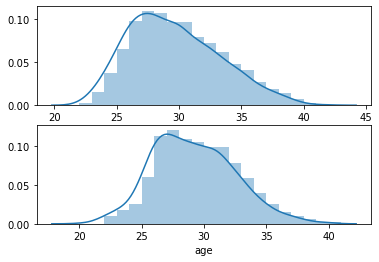

In [37]:
fig, ax = plt.subplots(2,1)
sns.distplot(salaries_stats_first_round['age'], bins=np.arange(22, 42), ax=ax[0])
sns.distplot(salaries_stats_second_round['age'], bins=np.arange(22, 42), ax=ax[1])

In [29]:
salaries_stats_first_round.loc[salaries_stats_first_round['minutes_played'] >= 600].sort_values('cap_space_usage', ascending=False)

,names,player_id,salary,season,season_end,season_start,key,years,name,positions,age,team,games_played,minutes_played,player_efficiency_rating,true_shooting_percentage,three_point_attempt_rate,free_throw_attempt_rate,offensive_rebound_percentage,defensive_rebound_percentage,total_rebound_percentage,assist_percentage,steal_percentage,block_percentage,turnover_percentage,usage_percentage,offensive_win_shares,defensive_win_shares,win_shares,win_shares_per_48_minutes,offensive_box_plus_minus,defensive_box_plus_minus,box_plus_minus,value_over_replacement_player,is_combined_totals,Year,slug,salary_cap,cap_space_usage
4759,Kevin Garnett,garneke01,28000000,2003-04,2004,2003,garneke01 2003-04,9,Kevin Garnett,POWER FORWARD,27.0,MINNESOTA TIMBERWOLVES,82.0,3231.0,29.4,0.547,0.027,0.289,9.1,30.0,20.1,24.4,2.0,4.0,10.5,29.6,10.4,8.0,18.3,0.272,6.8,3.3,10.2,10.0,False,2003-04,garneke01,43840000,0.638686
10315,Shaquille O'Neal,onealsh01,27696430,2004-05,2005,2004,onealsh01 2004-05,13,Shaquille O'Neal,CENTER,32.0,MIAMI HEAT,73.0,2492.0,27.0,0.583,0.000,0.699,12.4,22.8,17.8,15.7,0.8,5.0,12.4,30.5,6.4,4.6,11.0,0.211,4.1,1.2,5.3,4.6,False,2004-05,onealsh01,43870000,0.631330
4758,Kevin Garnett,garneke01,25200000,2002-03,2003,2002,garneke01 2002-03,8,Kevin Garnett,POWER FORWARD,26.0,MINNESOTA TIMBERWOLVES,82.0,3321.0,26.4,0.553,0.048,0.339,8.6,28.5,18.8,25.8,1.8,2.8,11.9,26.4,9.8,5.8,15.6,0.225,6.0,2.4,8.4,8.7,False,2002-03,garneke01,40271000,0.625760
4254,Patrick Ewing,ewingpa01,18500000,1998-99,1999,1998,ewingpa01 1998-99,14,Patrick Ewing,CENTER,36.0,NEW YORK KNICKS,38.0,1300.0,19.4,0.491,0.004,0.407,7.0,26.5,17.1,7.0,1.3,6.0,12.9,28.4,0.2,3.1,3.3,0.123,0.1,1.8,1.9,1.3,False,1998-99,ewingpa01,30000000,0.616667
10313,Shaquille O'Neal,onealsh01,23571429,2002-03,2003,2002,onealsh01 2002-03,11,Shaquille O'Neal,CENTER,30.0,LOS ANGELES LAKERS,67.0,2535.0,29.5,0.602,0.000,0.599,11.4,21.6,16.5,16.2,0.8,4.5,11.4,30.2,10.2,3.0,13.2,0.250,6.4,0.1,6.5,5.5,False,2002-03,onealsh01,40271000,0.585320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1711,Corey Brewer,breweco01,340829,2017-18,2018,2017,breweco01 2017-18,12,Corey Brewer,SMALL FORWARD,31.0,LOS ANGELES LAKERS,54.0,694.0,8.9,0.509,0.250,0.297,3.6,10.7,7.1,8.1,2.8,0.9,16.3,14.2,-0.2,0.9,0.7,0.048,-4.7,1.6,-3.1,-0.2,False,2017-18,breweco01,99093000,0.003439
6606,Allen Iverson,iversal01,161386,2009-10,2010,2009,iversal01 2009-10,15,Allen Iverson,SHOOTING GUARD,34.0,PHILADELPHIA 76ERS,25.0,798.0,13.1,0.508,0.083,0.410,2.2,9.0,5.5,20.4,1.2,0.2,14.3,22.8,0.4,0.2,0.6,0.034,-1.2,-1.9,-3.1,-0.2,False,2009-10,iversal01,57700000,0.002797
14605,Deron Williams,willide01,259626,2016-17,2017,2016,willide01 2016-17,15,Deron Williams,POINT GUARD,32.0,DALLAS MAVERICKS,40.0,1171.0,15.0,0.533,0.400,0.185,1.2,9.3,5.1,40.1,1.1,0.2,16.7,23.7,1.1,0.7,1.8,0.073,0.5,-1.8,-1.3,0.2,False,2016-17,willide01,94143000,0.002758
7344,Terrence Jones,joneste01,236457,2016-17,2017,2016,joneste01 2016-17,6,Terrence Jones,POWER FORWARD,25.0,NEW ORLEANS PELICANS,51.0,1264.0,16.2,0.518,0.153,0.348,5.4,20.0,12.6,7.5,1.5,3.4,7.8,21.4,0.5,1.8,2.3,0.088,-0.9,0.4,-0.5,0.5,False,2016-17,joneste01,94143000,0.002512


0.5667441270666084

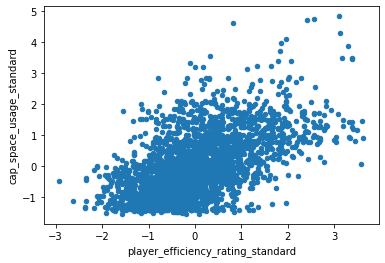

In [39]:
scatter_and_correlation(salaries_stats_first_round.loc[salaries_stats_first_round['minutes_played'] >= 800], 'player_efficiency_rating', 'cap_space_usage')

0.4242990078852054

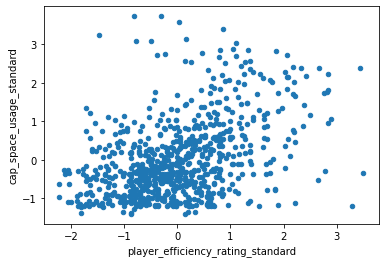

In [41]:
scatter_and_correlation(salaries_stats_second_round.loc[salaries_stats_second_round['minutes_played'] >= 800], 'player_efficiency_rating', 'cap_space_usage')